# Data Catalogue Analysis – IDC

This notebook includes:

- Retrieving metadata from the IDC API

- Comparing the available collections on the IDC website vs. IDC API

- Visualizing the distribution of available collections via the IDC API

- Obtaining a list of unique patient IDs (via the IDC API), which can be used to query the Genomic Data Commons (GDC)

In [1]:
# Import libraries
from tcia_utils import nbia
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2
import requests
import json
import pandas as pd

## Retrieving metadata from the IDC API

In [4]:
# Get a list of Collections available in IDC API
# IDC API endpoint
idc_api_preamble = 'https://api.imaging.datacommons.cancer.gov/v2'

# Get collections
response = requests.get(f'{idc_api_preamble}/collections')
response.raise_for_status()  # Raise an error if request failed

data = response.json()
df = pd.DataFrame(data['collections'])
collections_list = sorted(df['collection_id'].unique())

print(len(collections_list))
print(collections_list)

161
['4d_lung', 'acrin_6698', 'acrin_contralateral_breast_mr', 'acrin_flt_breast', 'acrin_nsclc_fdg_pet', 'adrenal_acc_ki67_seg', 'advanced_mri_breast_lesions', 'anti_pd_1_lung', 'b_mode_and_ceus_liver', 'bonemarrowwsi_pediatricleukemia', 'breast_cancer_screening_dbt', 'breast_diagnosis', 'breast_mri_nact_pilot', 'c4kc_kits', 'cbis_ddsm', 'cc_radiomics_phantom', 'cc_radiomics_phantom_2', 'cc_radiomics_phantom_3', 'cc_tumor_heterogeneity', 'ccdi_mci', 'cmb_aml', 'cmb_brca', 'cmb_crc', 'cmb_gec', 'cmb_lca', 'cmb_mel', 'cmb_mml', 'cmb_ov', 'cmb_pca', 'cmmd', 'colorectal_liver_metastases', 'covid_19_ar', 'covid_19_ny_sbu', 'cptac_aml', 'cptac_brca', 'cptac_ccrcc', 'cptac_cm', 'cptac_coad', 'cptac_gbm', 'cptac_hnscc', 'cptac_lscc', 'cptac_luad', 'cptac_ov', 'cptac_pda', 'cptac_sar', 'cptac_ucec', 'ct4harmonization_multicentric', 'ct_colonography', 'ct_lymph_nodes', 'ct_phantom4radiomics', 'ct_vs_pet_ventilation_imaging', 'ctpred_sunitinib_pannet', 'dro_toolkit', 'duke_breast_cancer_mri', 'e

In [ ]:
# Retrieve data catalogues iteratively for each Collection and concatanate them into a single big catalogue
# Fields to retrieve
fields = [
    'SeriesInstanceUID',
    'StudyInstanceUID',
    'Modality',
    'BodyPartExamined',
    'PatientID',
    'collection_id',
    'CancerType',
]

df_list = []

# Loop over collections
for i, collection_id in enumerate(collections_list, start=1):
    print(f"Processing {i}/{len(collections_list)}: {collection_id}")
    
    filters = {"collection_id": [collection_id]}

    cohortSpec = {
        "name": "testcohort",
        "description": "Test description",
        "filters": filters
    }

    manifestPreviewBody = {
        "cohort_def": cohortSpec,
        "fields": fields,
        "page_size": 9999999
    }

    headers = {
        'Accept': 'application/json',
        'Content-Type': 'application/json'
    }

    try:
        response = requests.post(
            f'{idc_api_preamble}/cohorts/manifest/preview/',
            data=json.dumps(manifestPreviewBody),
            headers=headers
        )
        response.raise_for_status()
        data = response.json()
        df2 = pd.DataFrame(data['manifest']['manifest_data'])
        print(f"  {collection_id}: {len(df2['PatientID'].unique())} unique patients")
        df_list.append(df2)

    except requests.RequestException as e:
        print(f"  Failed for {collection_id}: {e}")
        continue

# Combine all dataframes
if df_list:
    big_df = pd.concat(df_list, ignore_index=True)
    big_df.to_pickle("data_catalogue_tcia_api.pkl")
    print("Saved data_catalogue_tcia_api.pkl")
else:
    print("No data fetched.")

In [62]:
# load python data dictionary
df_idc_api = pd.read_pickle("data_catalogue_idc_api.pkl")
df_idc_api = df_idc_api.rename(columns={'collection_id': 'Collection'})
df_idc_api['Collection'] = df_idc_api['Collection'].str.lower().str.replace("-", "_")

In [63]:
# Have a peek at the data
print(len(df_idc_api)) #length of the dataframe
print(df_idc_api.columns) # column names
print(df_idc_api.head()) #view first 4 rows of the dataframe

299212
Index(['BodyPartExamined', 'CancerType', 'Modality', 'PatientID',
       'SeriesInstanceUID', 'StudyInstanceUID', 'Collection'],
      dtype='object')
  BodyPartExamined                  CancerType Modality    PatientID  \
0             LUNG  Non-small Cell Lung Cancer       CT  111_HM10395   
1             LUNG  Non-small Cell Lung Cancer       CT  118_HM10395   
2             LUNG  Non-small Cell Lung Cancer       CT  111_HM10395   
3             LUNG  Non-small Cell Lung Cancer       CT  103_HM10395   
4             LUNG  Non-small Cell Lung Cancer       CT  107_HM10395   

                                   SeriesInstanceUID  \
0  1.3.6.1.4.1.14519.5.2.1.6834.5010.100037757822...   
1  1.3.6.1.4.1.14519.5.2.1.6834.5010.100049789635...   
2  1.3.6.1.4.1.14519.5.2.1.6834.5010.100055011459...   
3  1.3.6.1.4.1.14519.5.2.1.6834.5010.100089621274...   
4  1.3.6.1.4.1.14519.5.2.1.6834.5010.100137773791...   

                                    StudyInstanceUID Collection  
0  1.3

# Comparing the available collections on the TCIA website vs. the TCIA API

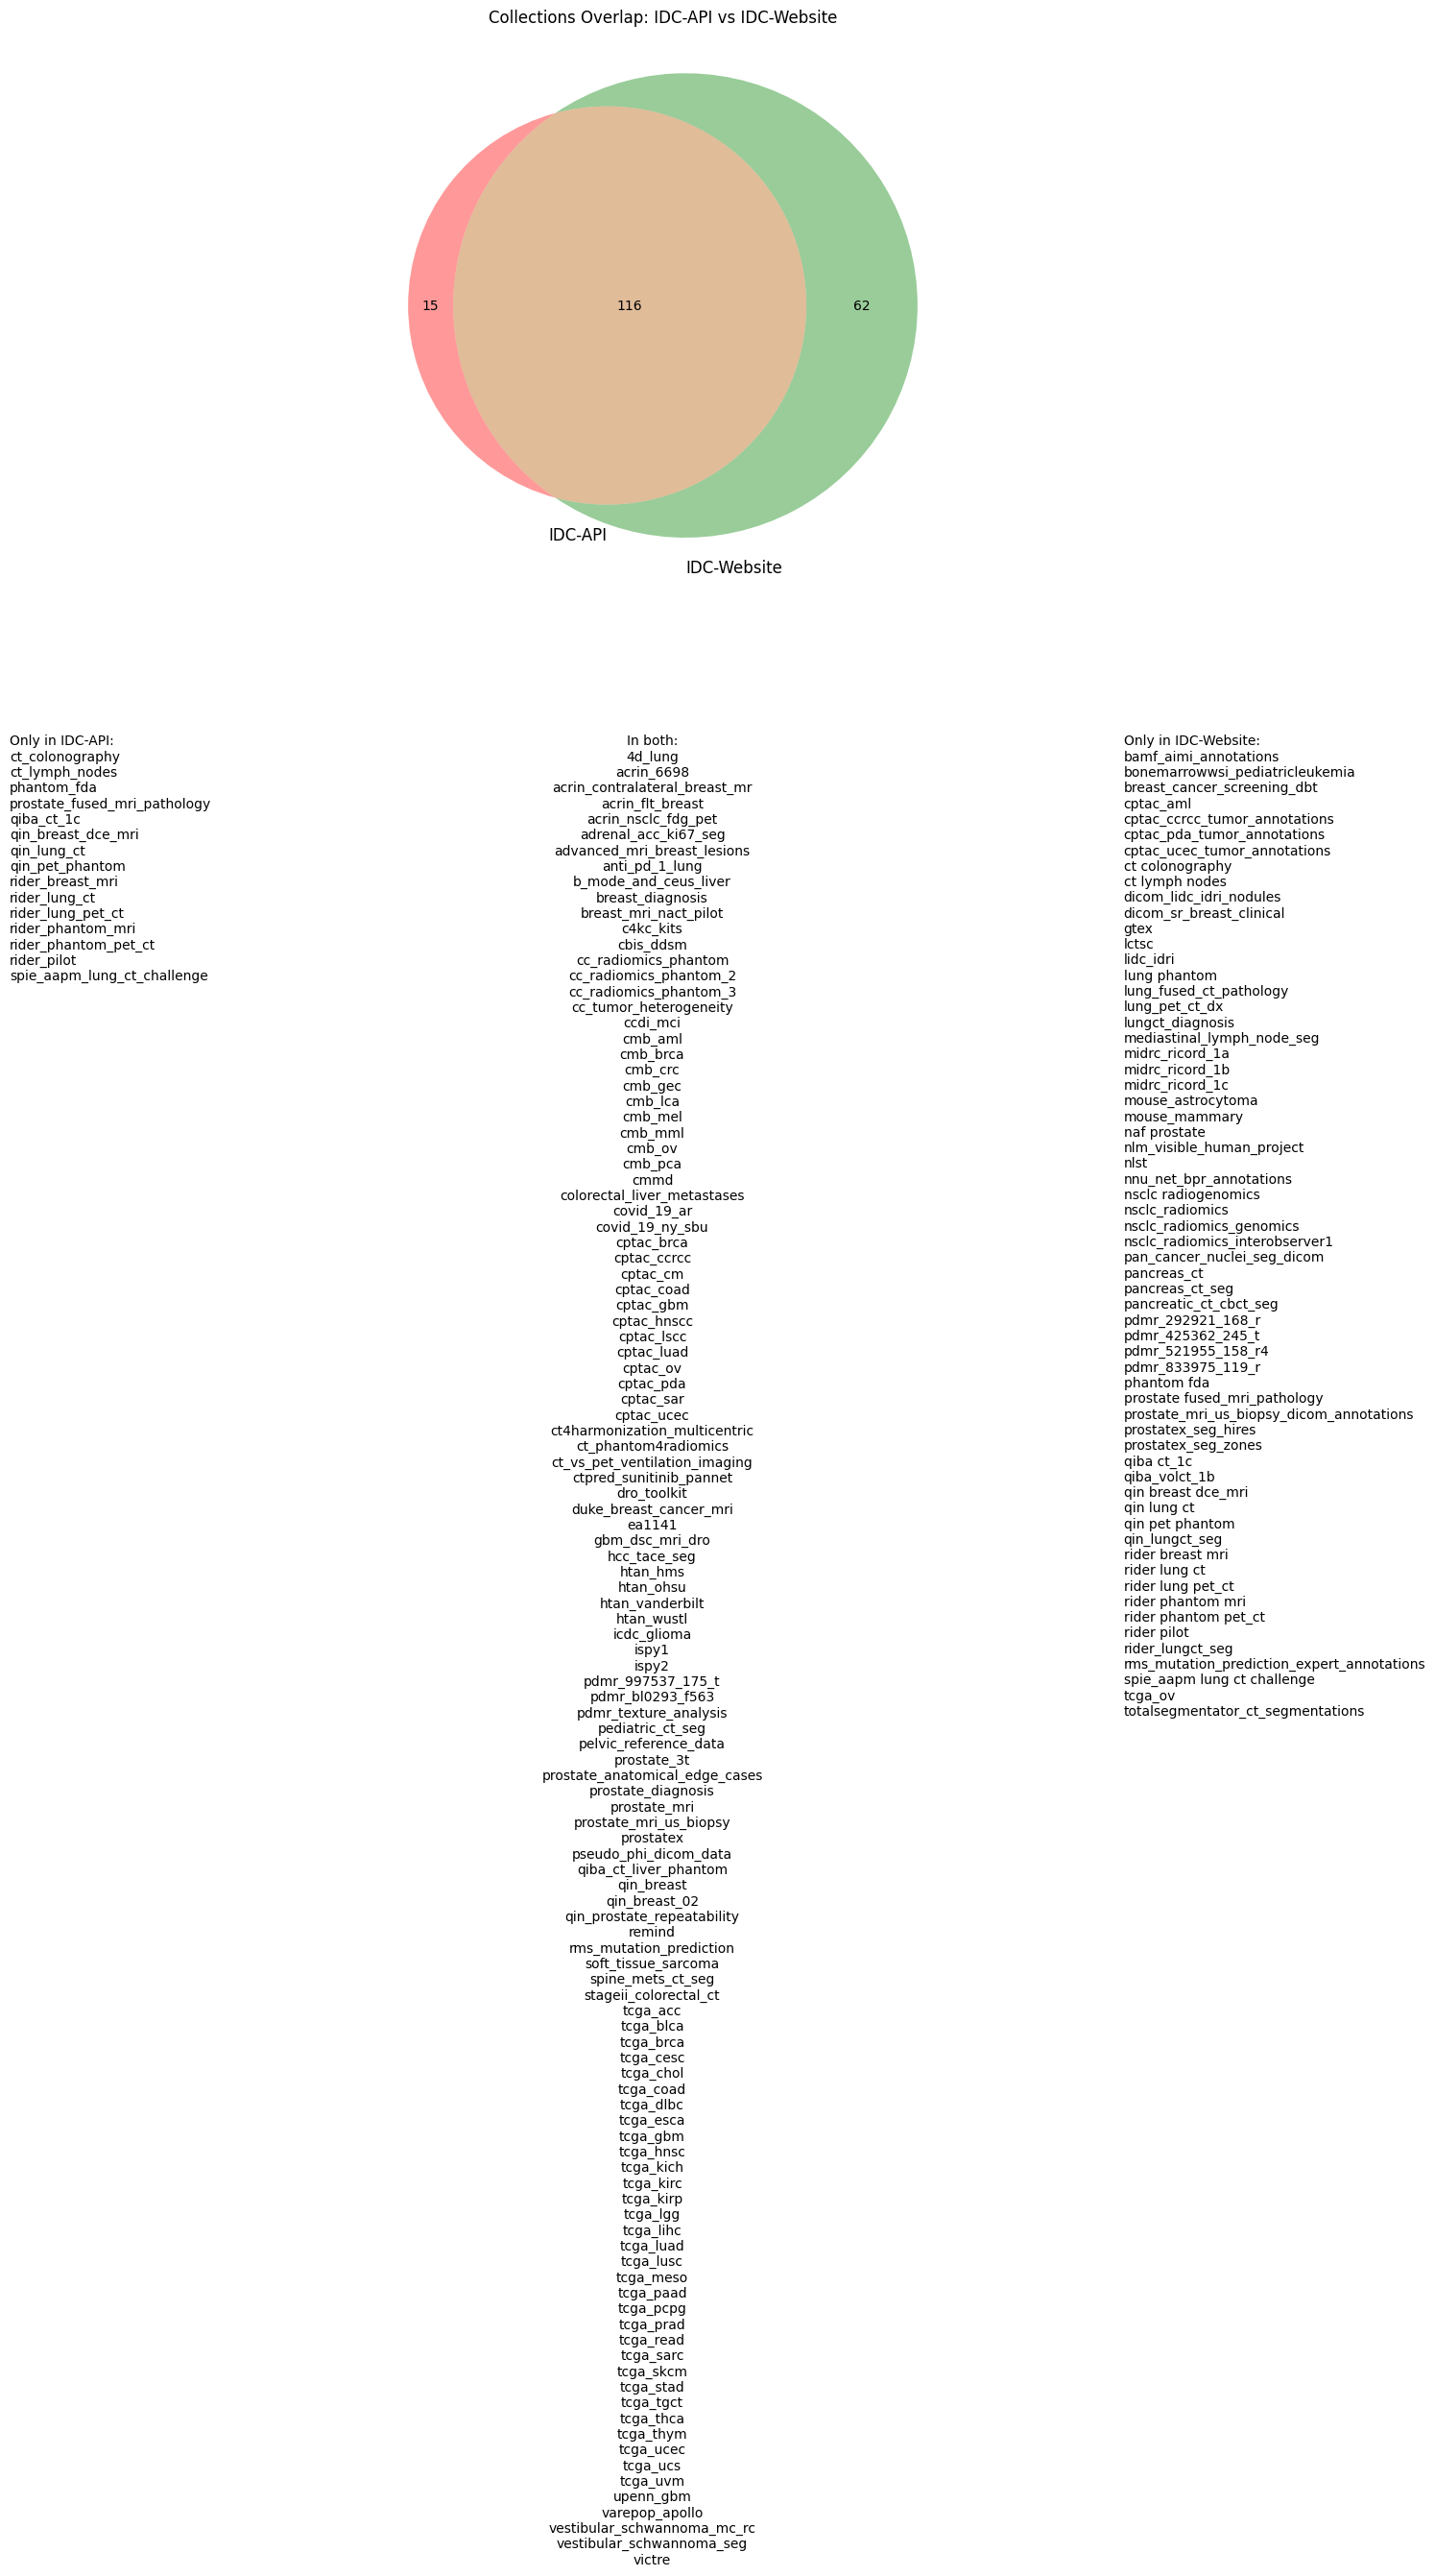

In [66]:
# Load TCIA metadata copies from the website
df_idc_web = pd.read_excel("data_catalogue_idc_web.xlsx")
df_idc_web = df_idc_web.rename(columns={'ID': 'Collection'})
df_idc_web = df_idc_web.rename(columns={'Subject Count': 'Subjects'})
df_idc_web['Collection'] = df_idc_web['Collection'].str.lower().str.replace("-", "_")

# Create Venn diagram to see which collections are there in the API and Website
u1 = set(df_idc_api['Collection'].unique())   # TCIA-API
u2 = set(df_idc_web['Collection'].unique())  # TCIA-Website

plt.figure(figsize=(8,8))
venn2([u1, u2], set_labels=('IDC-API', 'IDC-Website'))
plt.title('Collections Overlap: IDC-API vs IDC-Website')
only_api = sorted(u1 - u2)
only_web = sorted(u2 - u1)
both = sorted(u1 & u2)
plt.text(-1.5, -1.0, "Only in IDC-API:\n" + "\n".join(only_api), fontsize=10, verticalalignment='top')
plt.text(1.1, -1.0, "Only in IDC-Website:\n" + "\n".join(only_web), fontsize=10, verticalalignment='top')
plt.text(0, -1.0, "In both:\n" + "\n".join(both), fontsize=10, verticalalignment='top', horizontalalignment='center')
plt.axis('off')  # optional, hide axes
plt.show()

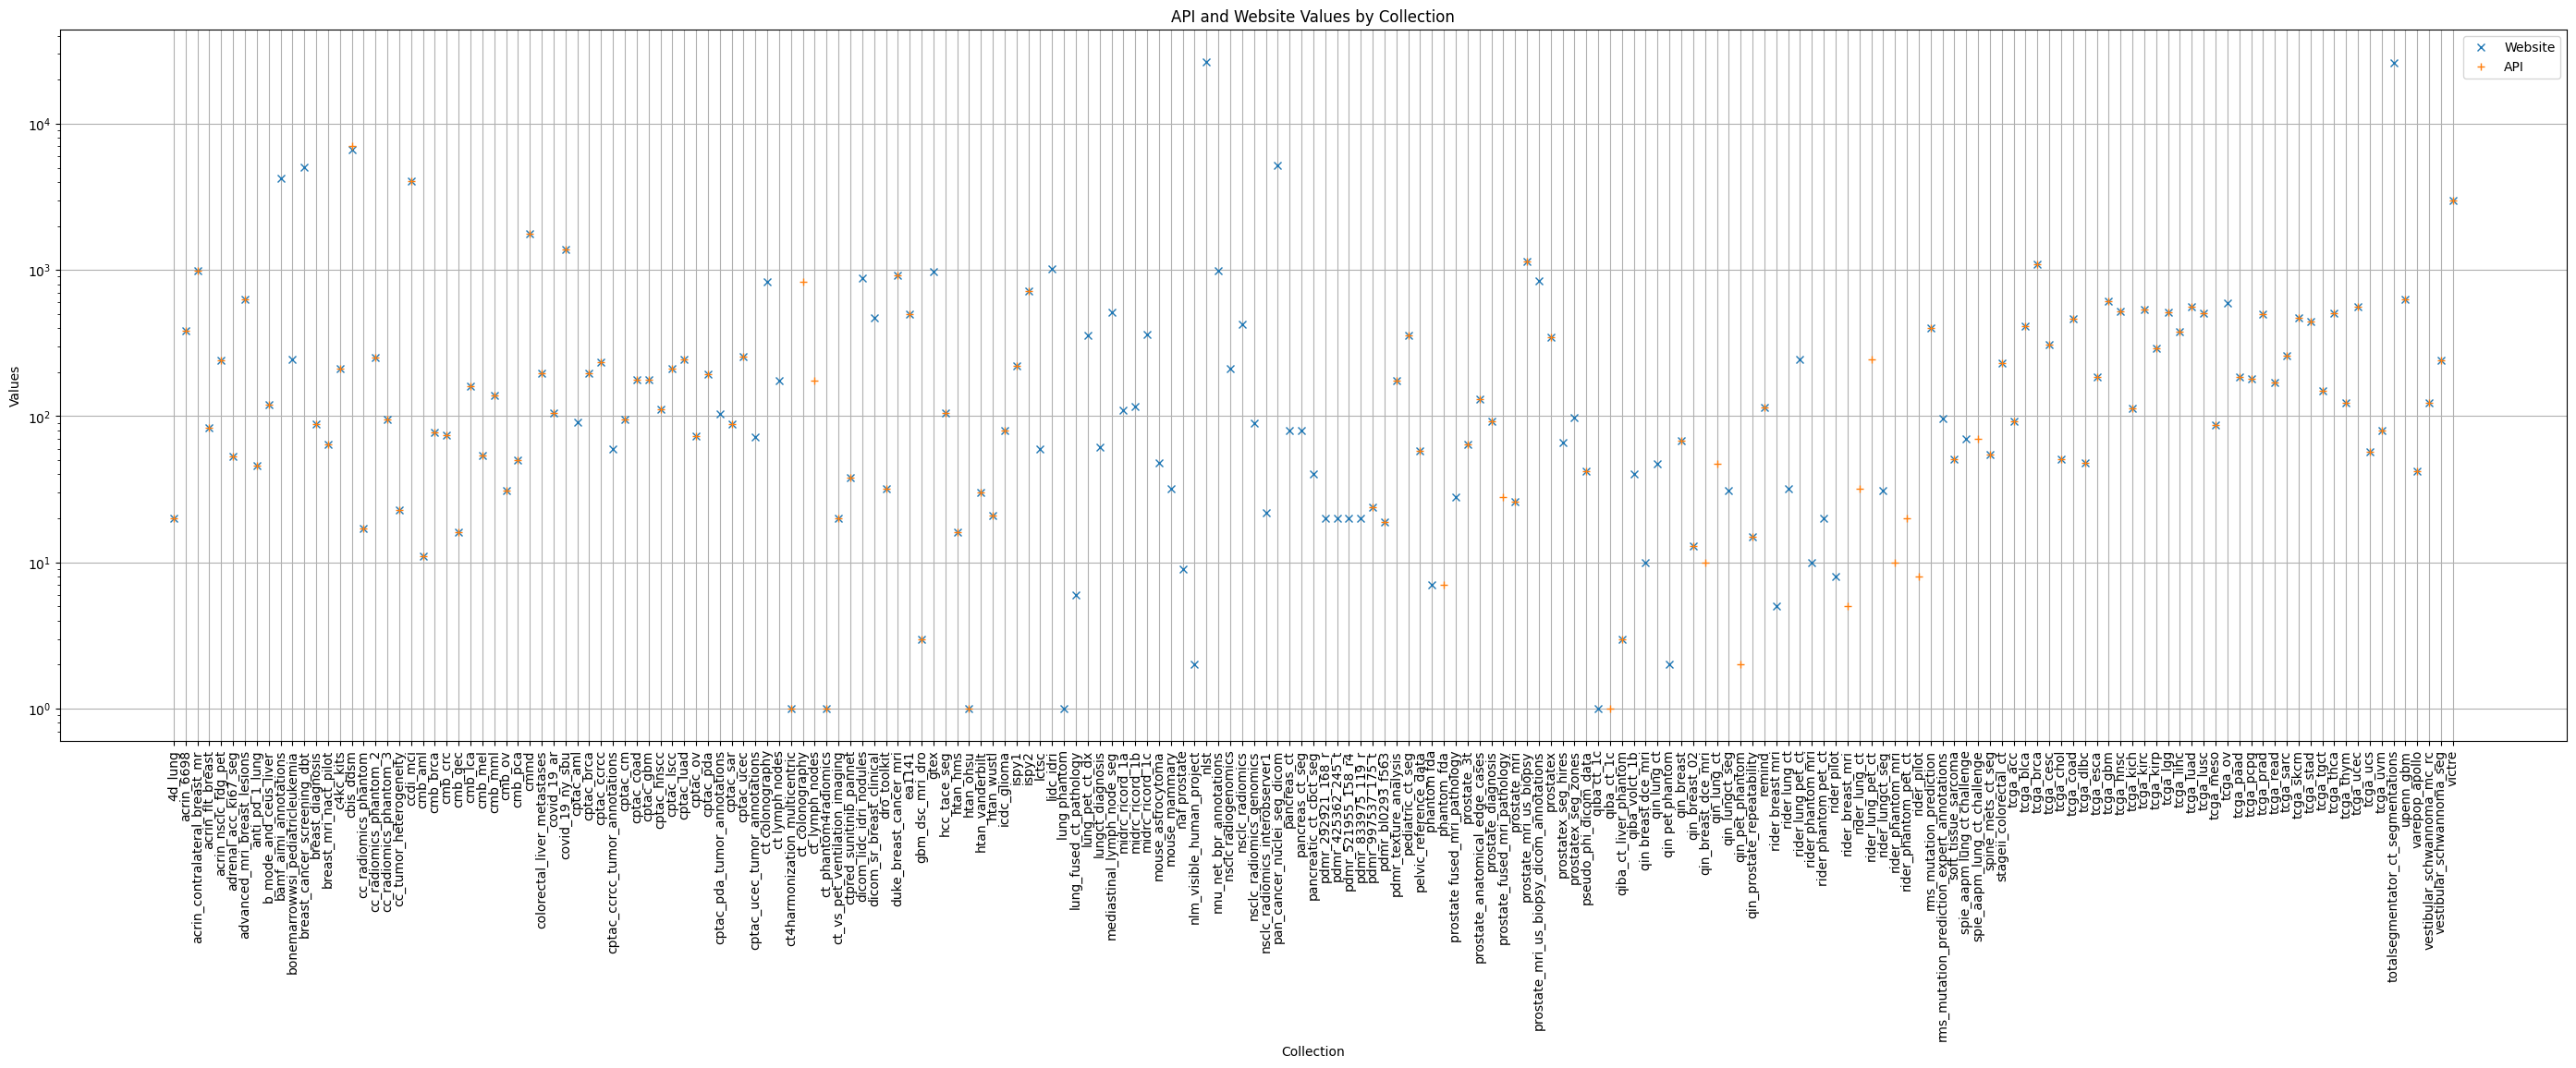

In [ ]:
# Let's compare the metadata (unique patient numbers) from API and Website
master_collection_list = list(set(df_idc_api['Collection'].unique()) | set(df_idc_web['Collection'].unique()))

count=0
compare = pd.DataFrame(columns=['Collection', 'API', 'Website'])
for collection in sorted(master_collection_list):
        filtered_df = df_idc_api[df_idc_api['Collection'] == collection]
        n = filtered_df['PatientID'].nunique()
        try:
                m = df_idc_web.loc[df_idc_web['Collection'] == collection, 'Subjects'].values[0]
        except:
                m = 0

        if n==0:
                n = None
        if m==0:
                m = None
        
        compare = pd.concat([compare, pd.DataFrame({'Collection':[collection], 'API':[n], 'Website':[m]})], ignore_index=True)


plt.figure(figsize=(35,10))
plt.plot(compare['Collection'], compare['Website'], marker='x', linestyle='', label='Website')
plt.plot(compare['Collection'], compare['API'], marker='+', linestyle='', label='API')

plt.xlabel('Collection')
plt.ylabel('Values')
plt.yscale('log')  # <-- set log scale

plt.xticks(rotation=90)
plt.title('API and Website Values by Collection')
plt.legend()
plt.grid(True)

# plt.savefig('api_website_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

# Visualizing the distribution of available collections via the TCIA API

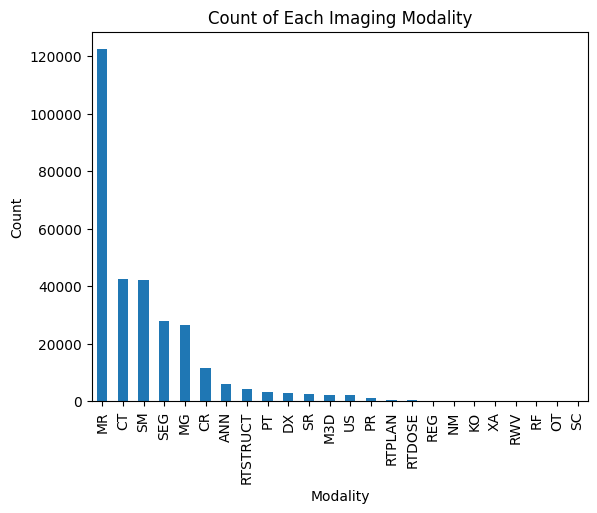

    Modality   Count
0         MR  122388
1         CT   42374
2         SM   42132
3        SEG   28067
4         MG   26413
5         CR   11655
6        ANN    6075
7   RTSTRUCT    4303
8         PT    3287
9         DX    2954
10        SR    2504
11       M3D    2328
12        US    2263
13        PR    1192
14    RTPLAN     484
15    RTDOSE     484
16       REG      97
17        NM      95
18        KO      40
19        XA      28
20       RWV      20
21        RF      12
22        OT      10
23        SC       7


In [68]:
# See what imaging modalities are available and how much
modality_counts = df_idc_api['Modality'].value_counts().reset_index()
df_idc_api['Modality'].value_counts().plot(kind='bar', title='Count of Each Imaging Modality')
plt.xlabel('Modality'); plt.ylabel('Count'); plt.show()
modality_counts.columns = ['Modality', 'Count']
print(modality_counts)

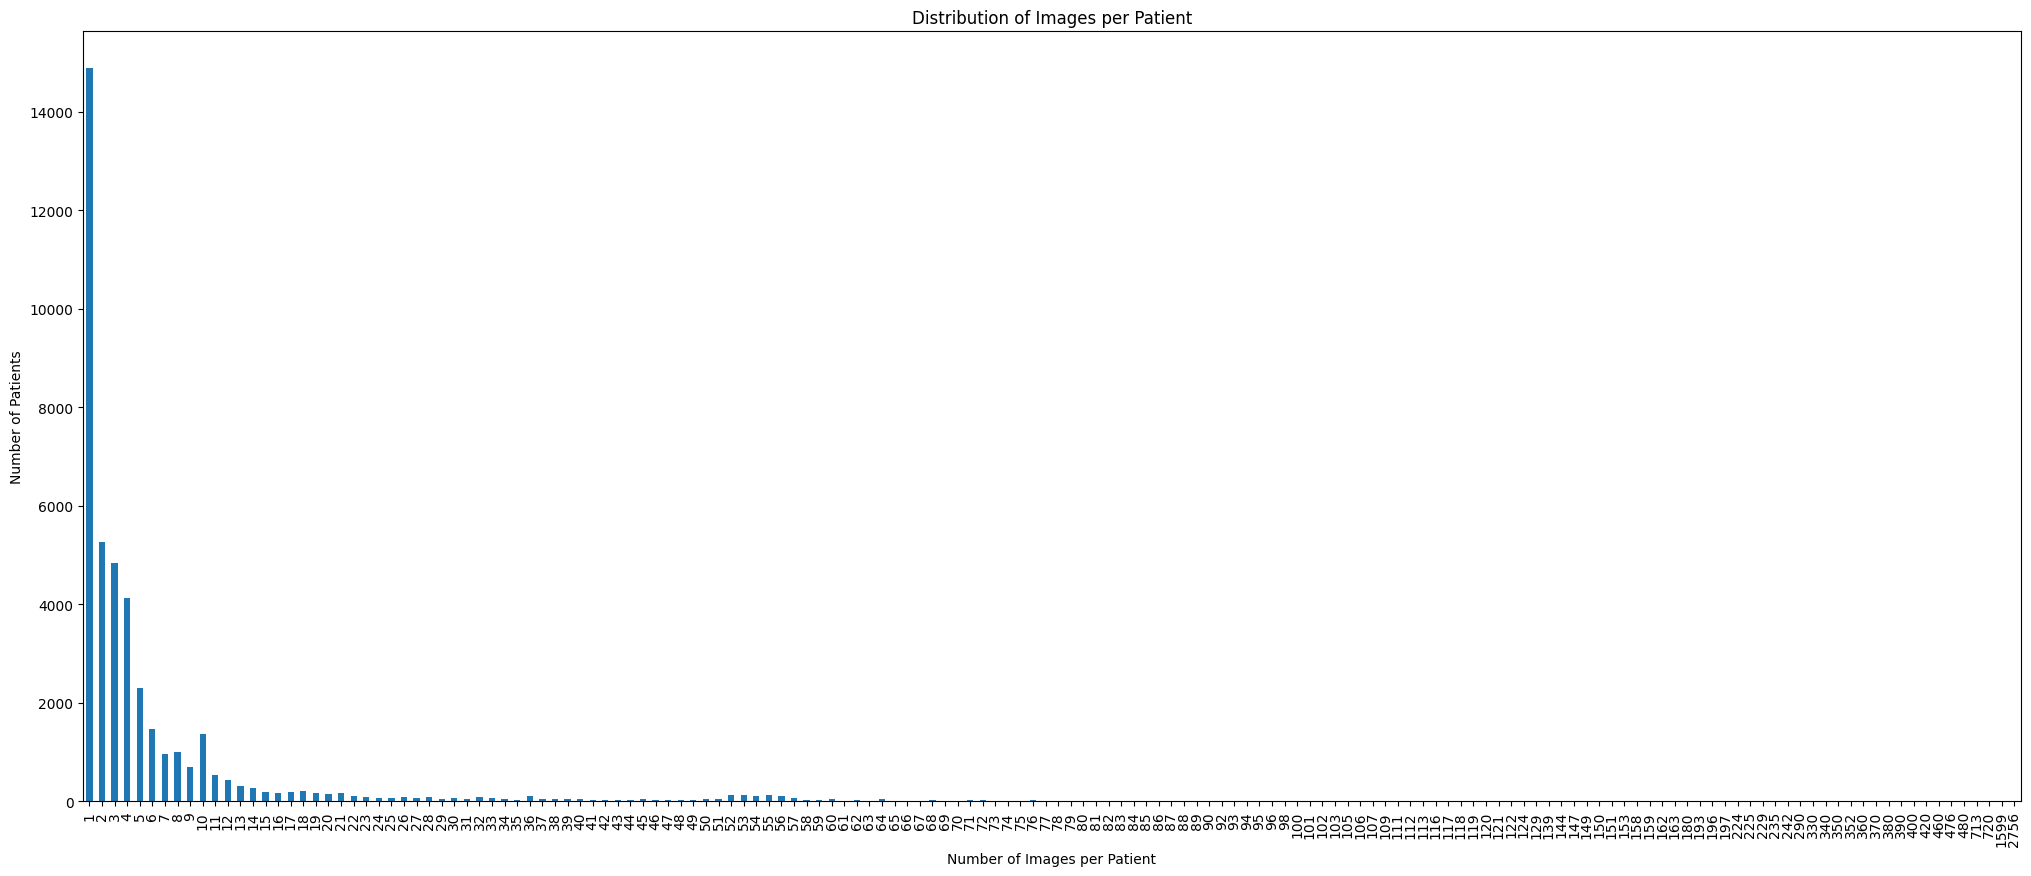

     num_images  num_patients
0             1         14884
1             2          5265
2             3          4835
3             4          4133
4             5          2302
..          ...           ...
149         480             1
150         713             1
151         720             4
152        1599             1
153        2756             1

[154 rows x 2 columns]


In [69]:
# See how many images are available per patient
counts = df_idc_api.groupby('PatientID').size()

plt.figure(figsize=(25,10))
counts.value_counts().sort_index().plot(kind='bar', title='Distribution of Images per Patient')
plt.xlabel('Number of Images per Patient'); plt.ylabel('Number of Patients'); plt.show()

distribution_table = counts.value_counts().sort_index().reset_index()
distribution_table.columns = ['num_images', 'num_patients']
print(distribution_table)

In [70]:
# Seemed some patients have more than 1000 images, which is suspicious!!! Let's check.
counts = df_idc_api.groupby('PatientID').size()
patients_over_1000 = counts[counts > 1000]
print(patients_over_1000) # Seems like they are phantoms!!!

PatientID
CT4Harmonization-Multicentric    2756
QIBA_CT_1C                       1599
dtype: int64


   Number of Unique Modalities  Number of Patients
0                            1               28126
1                            2                6583
2                            3                6072
3                            4                1514
4                            5                 249
5                            6                  14


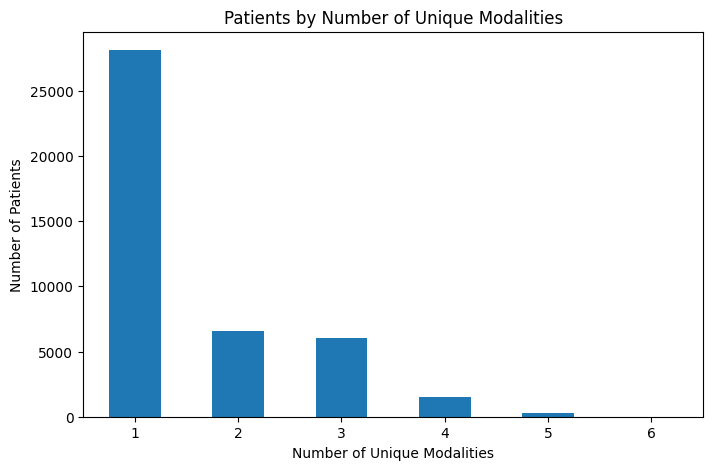

In [71]:
# See how many unique imaging modalities are available per patient
dist = df_idc_api.groupby('PatientID')['Modality'].nunique().value_counts().sort_index()
table = dist.reset_index()
table.columns = ['Number of Unique Modalities', 'Number of Patients']
print(table)

dist.plot(kind='bar', title='Patients by Number of Unique Modalities', figsize=(8,5))
plt.xlabel('Number of Unique Modalities'); plt.ylabel('Number of Patients'); plt.xticks(rotation=0)
plt.show()

In [ ]:
# One step further - see what combinations of modalities are common by patient
patient_modalities = df_idc_api.groupby('PatientID')['Modality'].apply(lambda x: tuple(sorted(x.unique())))
num_modalities = patient_modalities.apply(len)
dist = num_modalities.value_counts().sort_index().reset_index()
dist.columns = ['Number of Unique Modalities', 'Number of Patients']
combo_counts = patient_modalities.value_counts().reset_index()
combo_counts.columns = ['Combination', 'Count']
def top_n_combinations(n, N=5):
    combos = combo_counts[combo_counts['Combination'].apply(len) == n]
    top_combos = combos.sort_values('Count', ascending=False).head(N)['Combination'].tolist()
    top_combos += [()] * (N - len(top_combos))
    return top_combos
top_cols = ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5']
dist[top_cols] = dist['Number of Unique Modalities'].apply(lambda x: pd.Series(top_n_combinations(x)))
print(dist)

   Number of Unique Modalities  Number of Patients  \
0                            1               28126   
1                            2                6583   
2                            3                6072   
3                            4                1514   
4                            5                 249   
5                            6                  14   

                        Top 1                           Top 2  \
0                       (MG,)                           (SM,)   
1                   (MR, SEG)                       (CT, SEG)   
2              (ANN, SEG, SM)                   (CT, PT, SEG)   
3          (M3D, MR, SEG, US)  (MR, RTDOSE, RTPLAN, RTSTRUCT)   
4      (ANN, MR, SEG, SM, SR)          (ANN, CT, PT, SEG, SM)   
5  (ANN, CR, CT, DX, SEG, SM)      (ANN, MG, MR, SEG, SM, SR)   

                         Top 3                        Top 4  \
0                        (MR,)                        (CT,)   
1               (CT, RTSTRUCT)         

   BodyPartExamined  Number of Images
0            BREAST             84856
1          PROSTATE             22770
2             CHEST             21924
3           ABDOMEN              8561
4              LUNG              8007
..              ...               ...
61            SKULL                 2
62             BODY                 1
63            FEMUR                 1
64            ELBOW                 1
65          CTSPINE                 1

[66 rows x 2 columns]


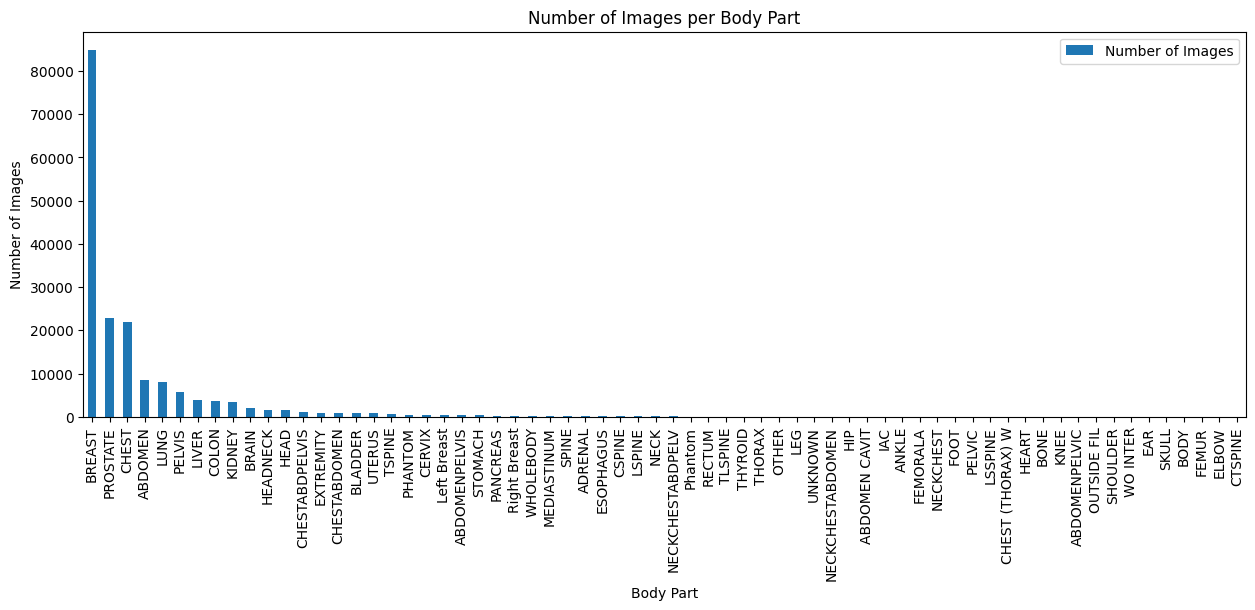

In [74]:
# Count number of images per body part
cancer_counts = df_idc_api['BodyPartExamined'].value_counts().reset_index(name='Number of Images')
print(cancer_counts)

cancer_counts.plot(kind='bar', x='BodyPartExamined', y='Number of Images', title='Number of Images per Body Part', figsize=(15,5))
plt.xlabel('Body Part'); plt.ylabel('Number of Images'); plt.xticks(rotation=90)
plt.show()

            Collection  Number of Images
0                ispy2             32411
1            prostatex             18832
2           acrin_6698             18747
3      covid_19_ny_sbu             17950
4               ea1141             14340
..                 ...               ...
126  rider_phantom_mri                45
127    qin_pet_phantom                44
128   rider_breast_mri                40
129           htan_hms                31
130    htan_vanderbilt                30

[131 rows x 2 columns]


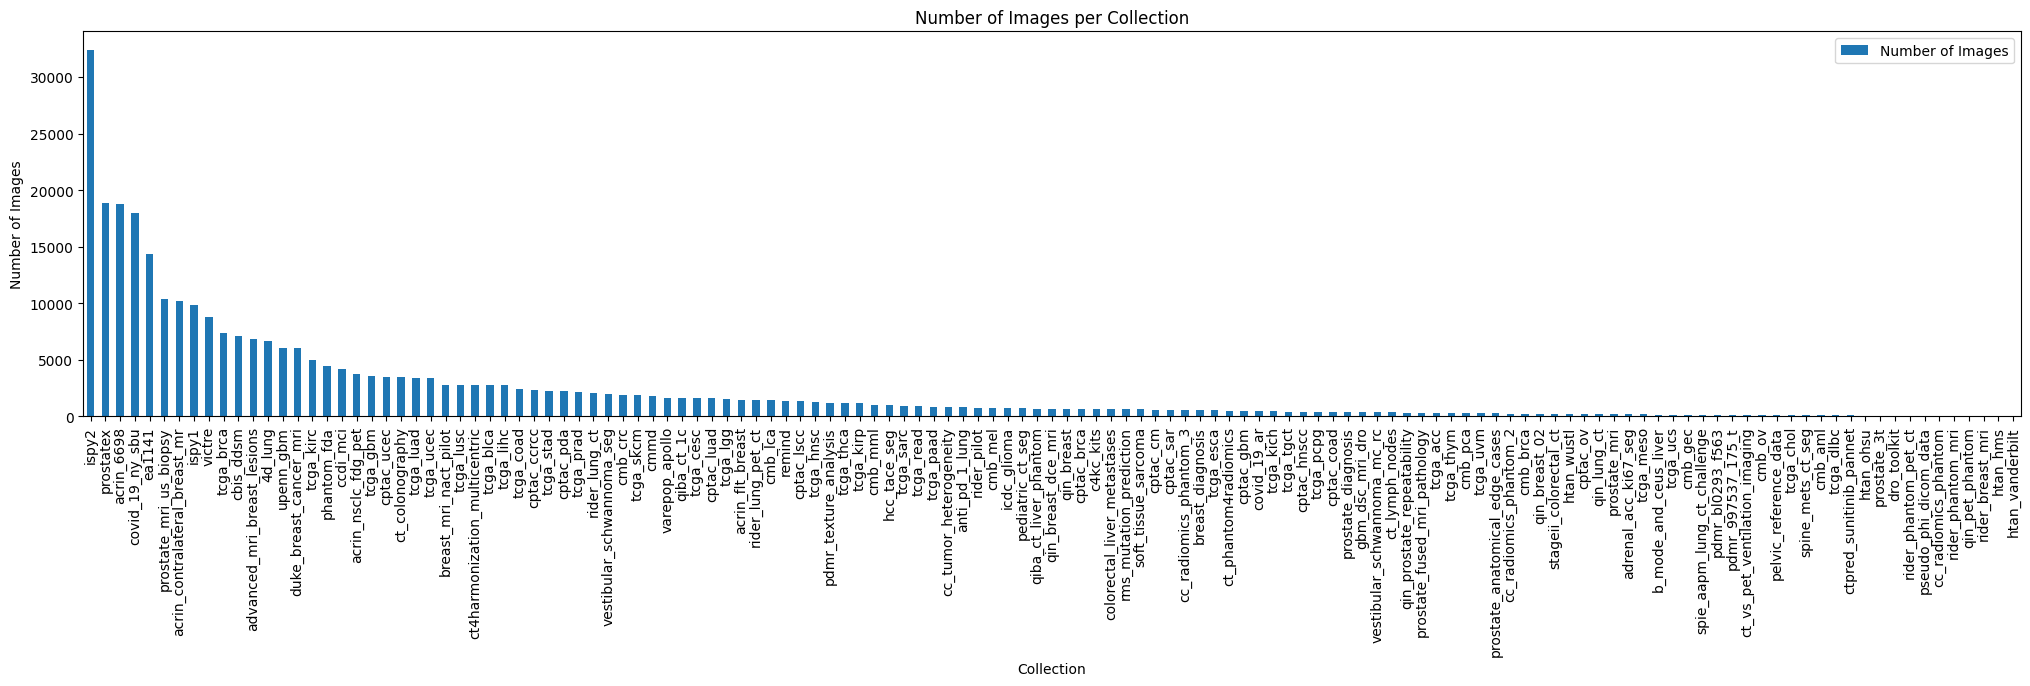

In [75]:
# Count number of images per Collection
cancer_counts = df_idc_api['Collection'].value_counts().reset_index(name='Number of Images')
print(cancer_counts)

cancer_counts.plot(kind='bar', x='Collection', y='Number of Images', title='Number of Images per Collection', figsize=(25,5))
plt.xlabel('Collection'); plt.ylabel('Number of Images'); plt.xticks(rotation=90)
plt.show()

   BodyPartExamined  Number of Patients
0            BREAST               16022
1             CHEST                2352
2           ABDOMEN                1454
3          PROSTATE                1022
4             COLON                 850
..              ...                 ...
61        NECKCHEST                   1
62           PELVIC                   1
63         SHOULDER                   1
64          TLSPINE                   1
65         WO INTER                   1

[66 rows x 2 columns]


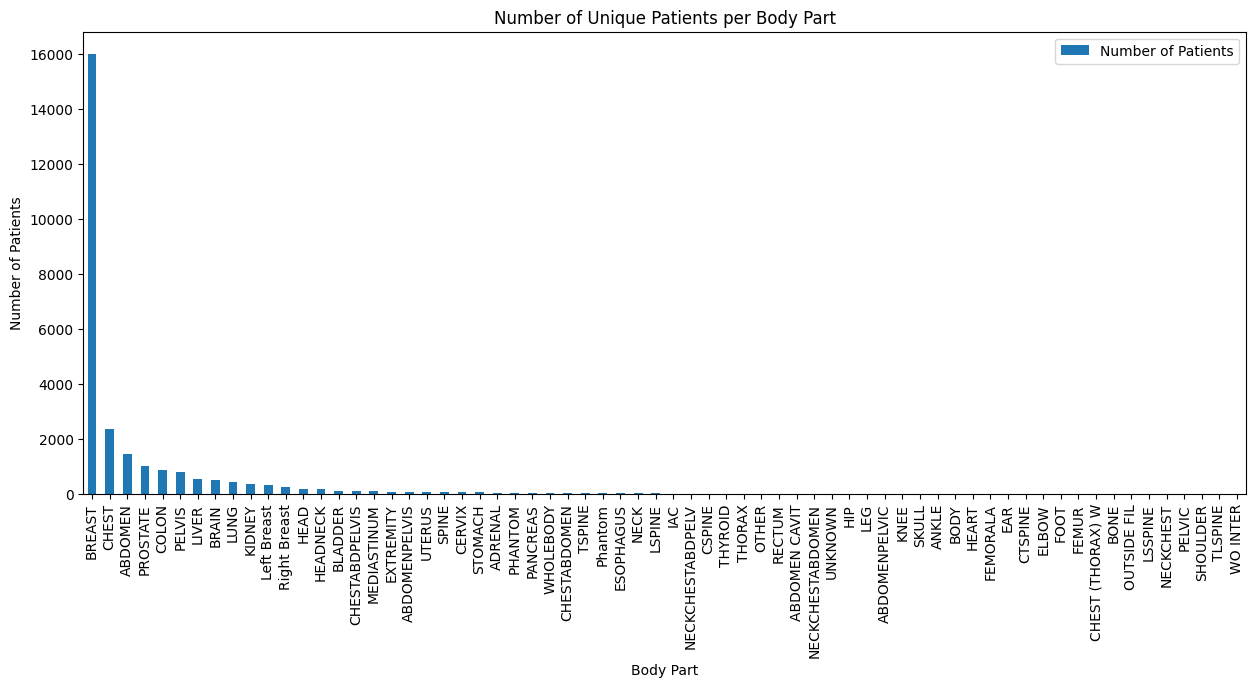

In [76]:
# Count number of patients per Body Part
patient_counts = df_idc_api.groupby('BodyPartExamined')['PatientID'].nunique().sort_values(ascending=False).reset_index(name='Number of Patients')
print(patient_counts)

patient_counts.plot(kind='bar', x='BodyPartExamined', y='Number of Patients', title='Number of Unique Patients per Body Part', figsize=(15,6))
plt.xlabel('Body Part'); plt.ylabel('Number of Patients'); plt.xticks(rotation=90); plt.show()

                        Collection  Number of Patients
0                        cbis_ddsm                6991
1                         ccdi_mci                4055
2                           victre                2994
3                             cmmd                1775
4                  covid_19_ny_sbu                1384
..                             ...                 ...
126                qin_pet_phantom                   2
127                      htan_ohsu                   1
128  ct4harmonization_multicentric                   1
129           ct_phantom4radiomics                   1
130                     qiba_ct_1c                   1

[131 rows x 2 columns]


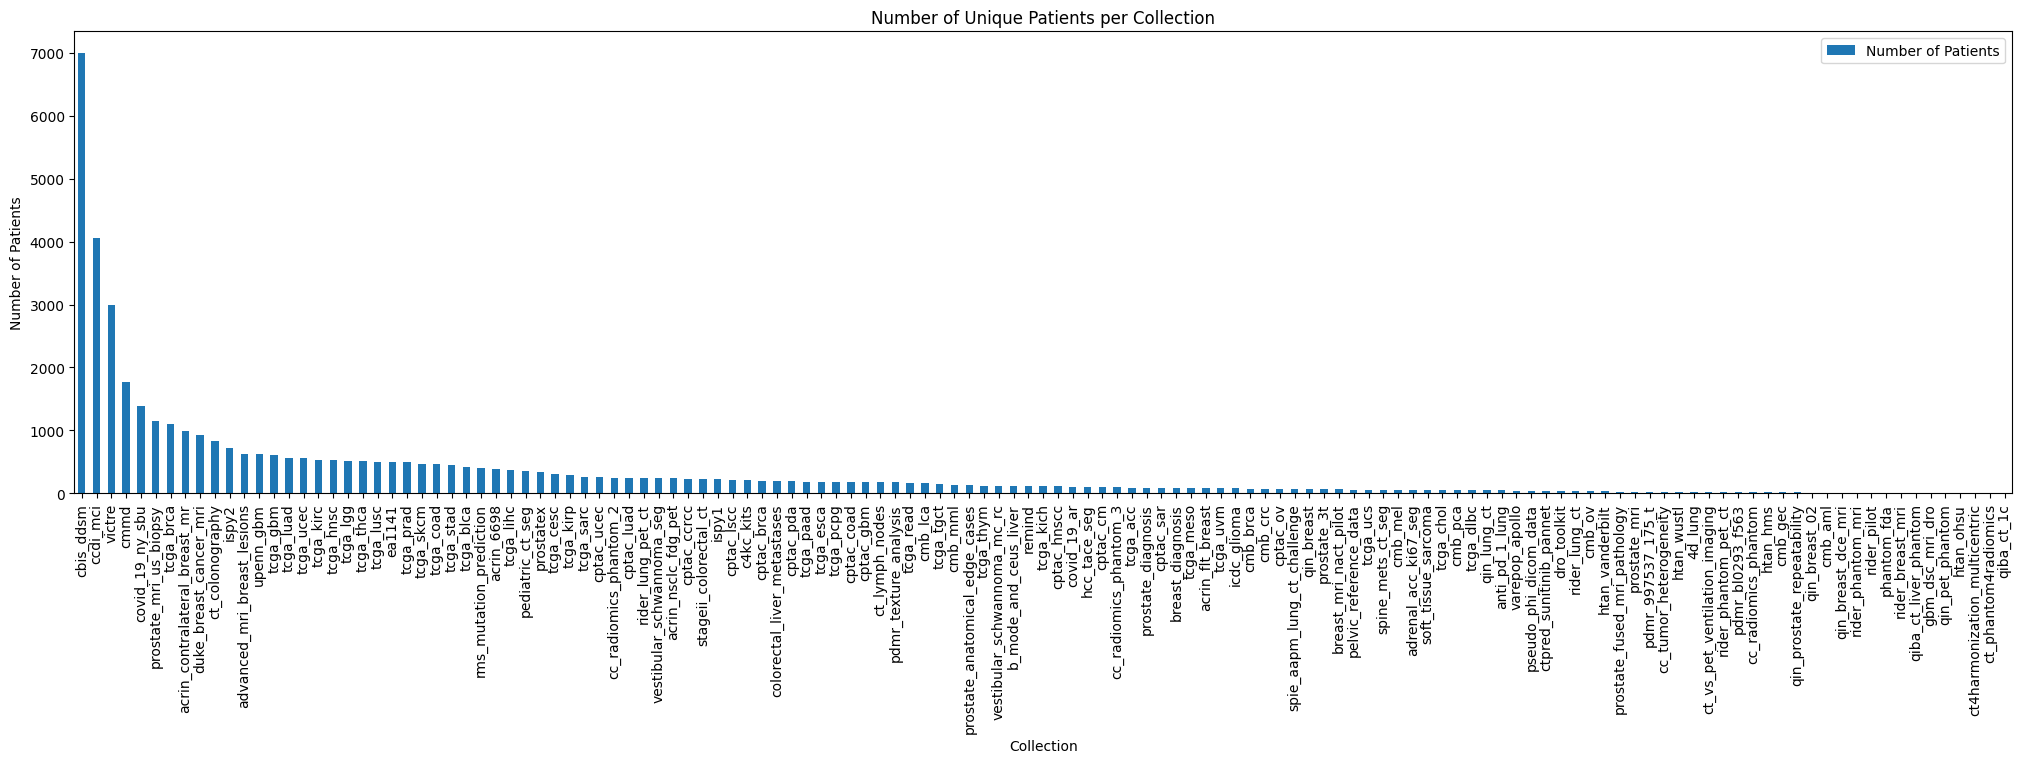

In [77]:
# Count number of patients per Collection
patient_counts = df_idc_api.groupby('Collection')['PatientID'].nunique().sort_values(ascending=False).reset_index(name='Number of Patients')
print(patient_counts)

patient_counts.plot(kind='bar', x='Collection', y='Number of Patients', title='Number of Unique Patients per Collection', figsize=(25,6))
plt.xlabel('Collection'); plt.ylabel('Number of Patients'); plt.xticks(rotation=90); plt.show()

In [78]:
# Now let's see how many unique Body Parts are there
print(len(df_idc_api['BodyPartExamined'].unique())) 
print(df_idc_api['BodyPartExamined'].unique())

67
['LUNG' None 'BREAST' 'TSPINE' 'CHEST' 'ABDOMEN' 'OUTSIDE FIL' 'THORAX'
 'CHESTABDPELVIS' 'ABDOMENPELVIS' 'CHEST (THORAX) W' 'BRAIN'
 'CHESTABDOMEN' 'HEAD' 'ADRENAL' 'LIVER' 'KIDNEY' 'WO INTER'
 'Right Breast' 'Left Breast' 'Phantom' 'PELVIS' 'WHOLEBODY' 'CSPINE'
 'LSPINE' 'SPINE' 'NECK' 'BODY' 'LEG' 'HIP' 'NECKCHESTABDPELV' 'FOOT'
 'NECKCHEST' 'NECKCHESTABDOMEN' 'EXTREMITY' 'SKULL' 'FEMUR' 'TLSPINE'
 'BLADDER' 'PELVIC' 'HEADNECK' 'ABDOMEN CAVIT' 'ABDOMENPELVIC' 'BONE'
 'LSSPINE' 'PANCREAS' 'COLON' 'MEDIASTINUM' 'PHANTOM' 'PROSTATE' 'UTERUS'
 'CERVIX' 'ESOPHAGUS' 'RECTUM' 'STOMACH' 'THYROID' 'OTHER' 'UNKNOWN'
 'FEMORALA' 'ANKLE' 'SHOULDER' 'ELBOW' 'HEART' 'KNEE' 'CTSPINE' 'EAR'
 'IAC']


# Obtaining a list of unique patient IDs (via the IDC API), which can be used to query the Genomic Data Commons (GDC)

In [80]:
# Now let's see how many unique patient are there and 
# save a list of unique patient IDs which can be use to filter the Genomic Data Commons (GDC) data
print(len(df_idc_api['PatientID'].unique())) 
print(df_idc_api['PatientID'].unique())

df = pd.DataFrame(df_idc_api['PatientID'].unique())
df.to_excel('patientIDs_idc_api.xlsx', index=False, header=False)

42558
['111_HM10395' '118_HM10395' '103_HM10395' ... '650648047' '365148239'
 '1812536825']
